In [25]:
import argparse


from models import *   
from sys import platform
from utils.datasets import *
from utils.utils import *

from IPython.core.display import Image, display


def detect():
    """
    Generates detections from images and saves the images to output file
    Input image is references with --source flag
    """
     
    cfg="cfg/yolov3-spp.cfg"
    conf_threshold=0.6 
    data= "data/asl_images/asl.data"
    devices=''
    nms_threshold= 0.1


    #    parser.add_argument('--weights', type=str, default='/home/mmvc/mmvc-ad-teachnas/CV_2019_Fall/msn307/simple-faster-rcnn-pytorch/checkpoints/fasterrcnn_12040256_0.9482940352213308', help='path to weights file')



    image_size = 416  # (height, width) =(320, 192) or (416, 256) or (608, 352)  
    out_folder, source_image, weights = "output", "data/asl_images/ASL-AtoE-Labeled/20191130_174504.jpg", "asl_weights/backup70.pt"

    # Delete output folder and make new folder to output the detection image
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder) #imported from datasets.py 
    os.makedirs(out_folder)   

    device = torch_utils.select_device(devices)

    # Set YOLOV3 model 
    model = YOLOV3(cfg, image_size)

    # Check if weights file is to be gotten online
    try_download(weights) #specific files names to test are defined in models.try_dowload

    # If the weights file ends in pt, it is in pytorch format
    # otherwise, it is an online weights file in darknet format
    if weights.endswith('.pt'):  
        model.load_state_dict(torch.load(weights, map_location=device)['model'])
    else:   
        _ = load_darknet_weights(model, weights)


    model.to(device).eval() # set model to evaluation mode
    

    # set the image loader, and load the classes and colors
    dataset = ImageLoader(source_image, image_size=image_size)
    classes_list = classes_load(data_cfg_parser(data)['names'])
    color_list = [[random.randint(0, 255) for i in range(3)] for class_ in range(len(classes_list))]

    
    # Inference over the images in path
    start_time = time.time()

    for path, image, image_originals, vid_cap in dataset:
        current_time = time.time()

        # Get detections
        image = torch.from_numpy(image).to(device)
        if image.ndimension() == 3:
            image = image.unsqueeze(0)
        prediction, _ = model(image)

        # Run non max suppression on the detection, display, and write image to output file
        for index, detection in enumerate(non_max_suppression(prediction, conf_threshold, nms_threshold)):  # detections per image
            
            # Note that shape of detection, since it is for one image, is [numboxes, (x1, y1, x2, y2, object_conf, class_conf, class)]
            pth, detection_names, original_image = path, '', image_originals  
 
            save_path = str(Path(out_folder) / Path(pth).name) # path to save the output image
            detection_names += '%gx%g ' % image.shape[2:]  # add image size to image description

            
            # If there is a detection available
            if detection is not None and len(detection):
                # Change box dimensions from image_size to original_image size
                detection[:, :4] = box_scale(image.shape[2:], detection[:, :4], original_image.shape).round()

                
                # For each class, add the class name and number of detections to the terminal output
                for class_ in detection[:, -1].unique():
                    num_dets = (detection[:, -1]==class_).sum()  
                    detection_names += '%g %ss, ' % (num_dets, classes_list[int(class_)])  # add to string
                
                
                print("\n\nDetection is >>>", classes_list[int(class_)], "\n\n")

                # Write results
                for *x1y1x2y2, obj_conf, _, class_ in detection:

                    # Bounding box addition
                    obj_label = '%s %.2f' % (classes_list[int(class_)], obj_conf)
                    single_box_plot(x1y1x2y2, original_image, obj_label=obj_label, color=color_list[int(class_)])

            print('%sDetection #%d complete. (%.3fs)' % (detection_names, index,  time.time() - current_time))

            # Show and save image detection results
#             cv2.imshow(pth, original_image)
            cv2.imwrite(save_path, original_image)
    
    display(Image("output/"+source_image.split('/')[-1], width=200, unconfined=True))


    print('Results saved to %s' % os.getcwd() + os.sep + out_folder)

    print('All detections complete. (%.3fs)' % (time.time() - start_time))

 

    

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7979MB)

image 1/1 data/asl_images/ASL-AtoE-Labeled/20191130_174504.jpg: 

Detection is >>> C 


416x256 1 Cs, Detection #0 complete. (0.015s)


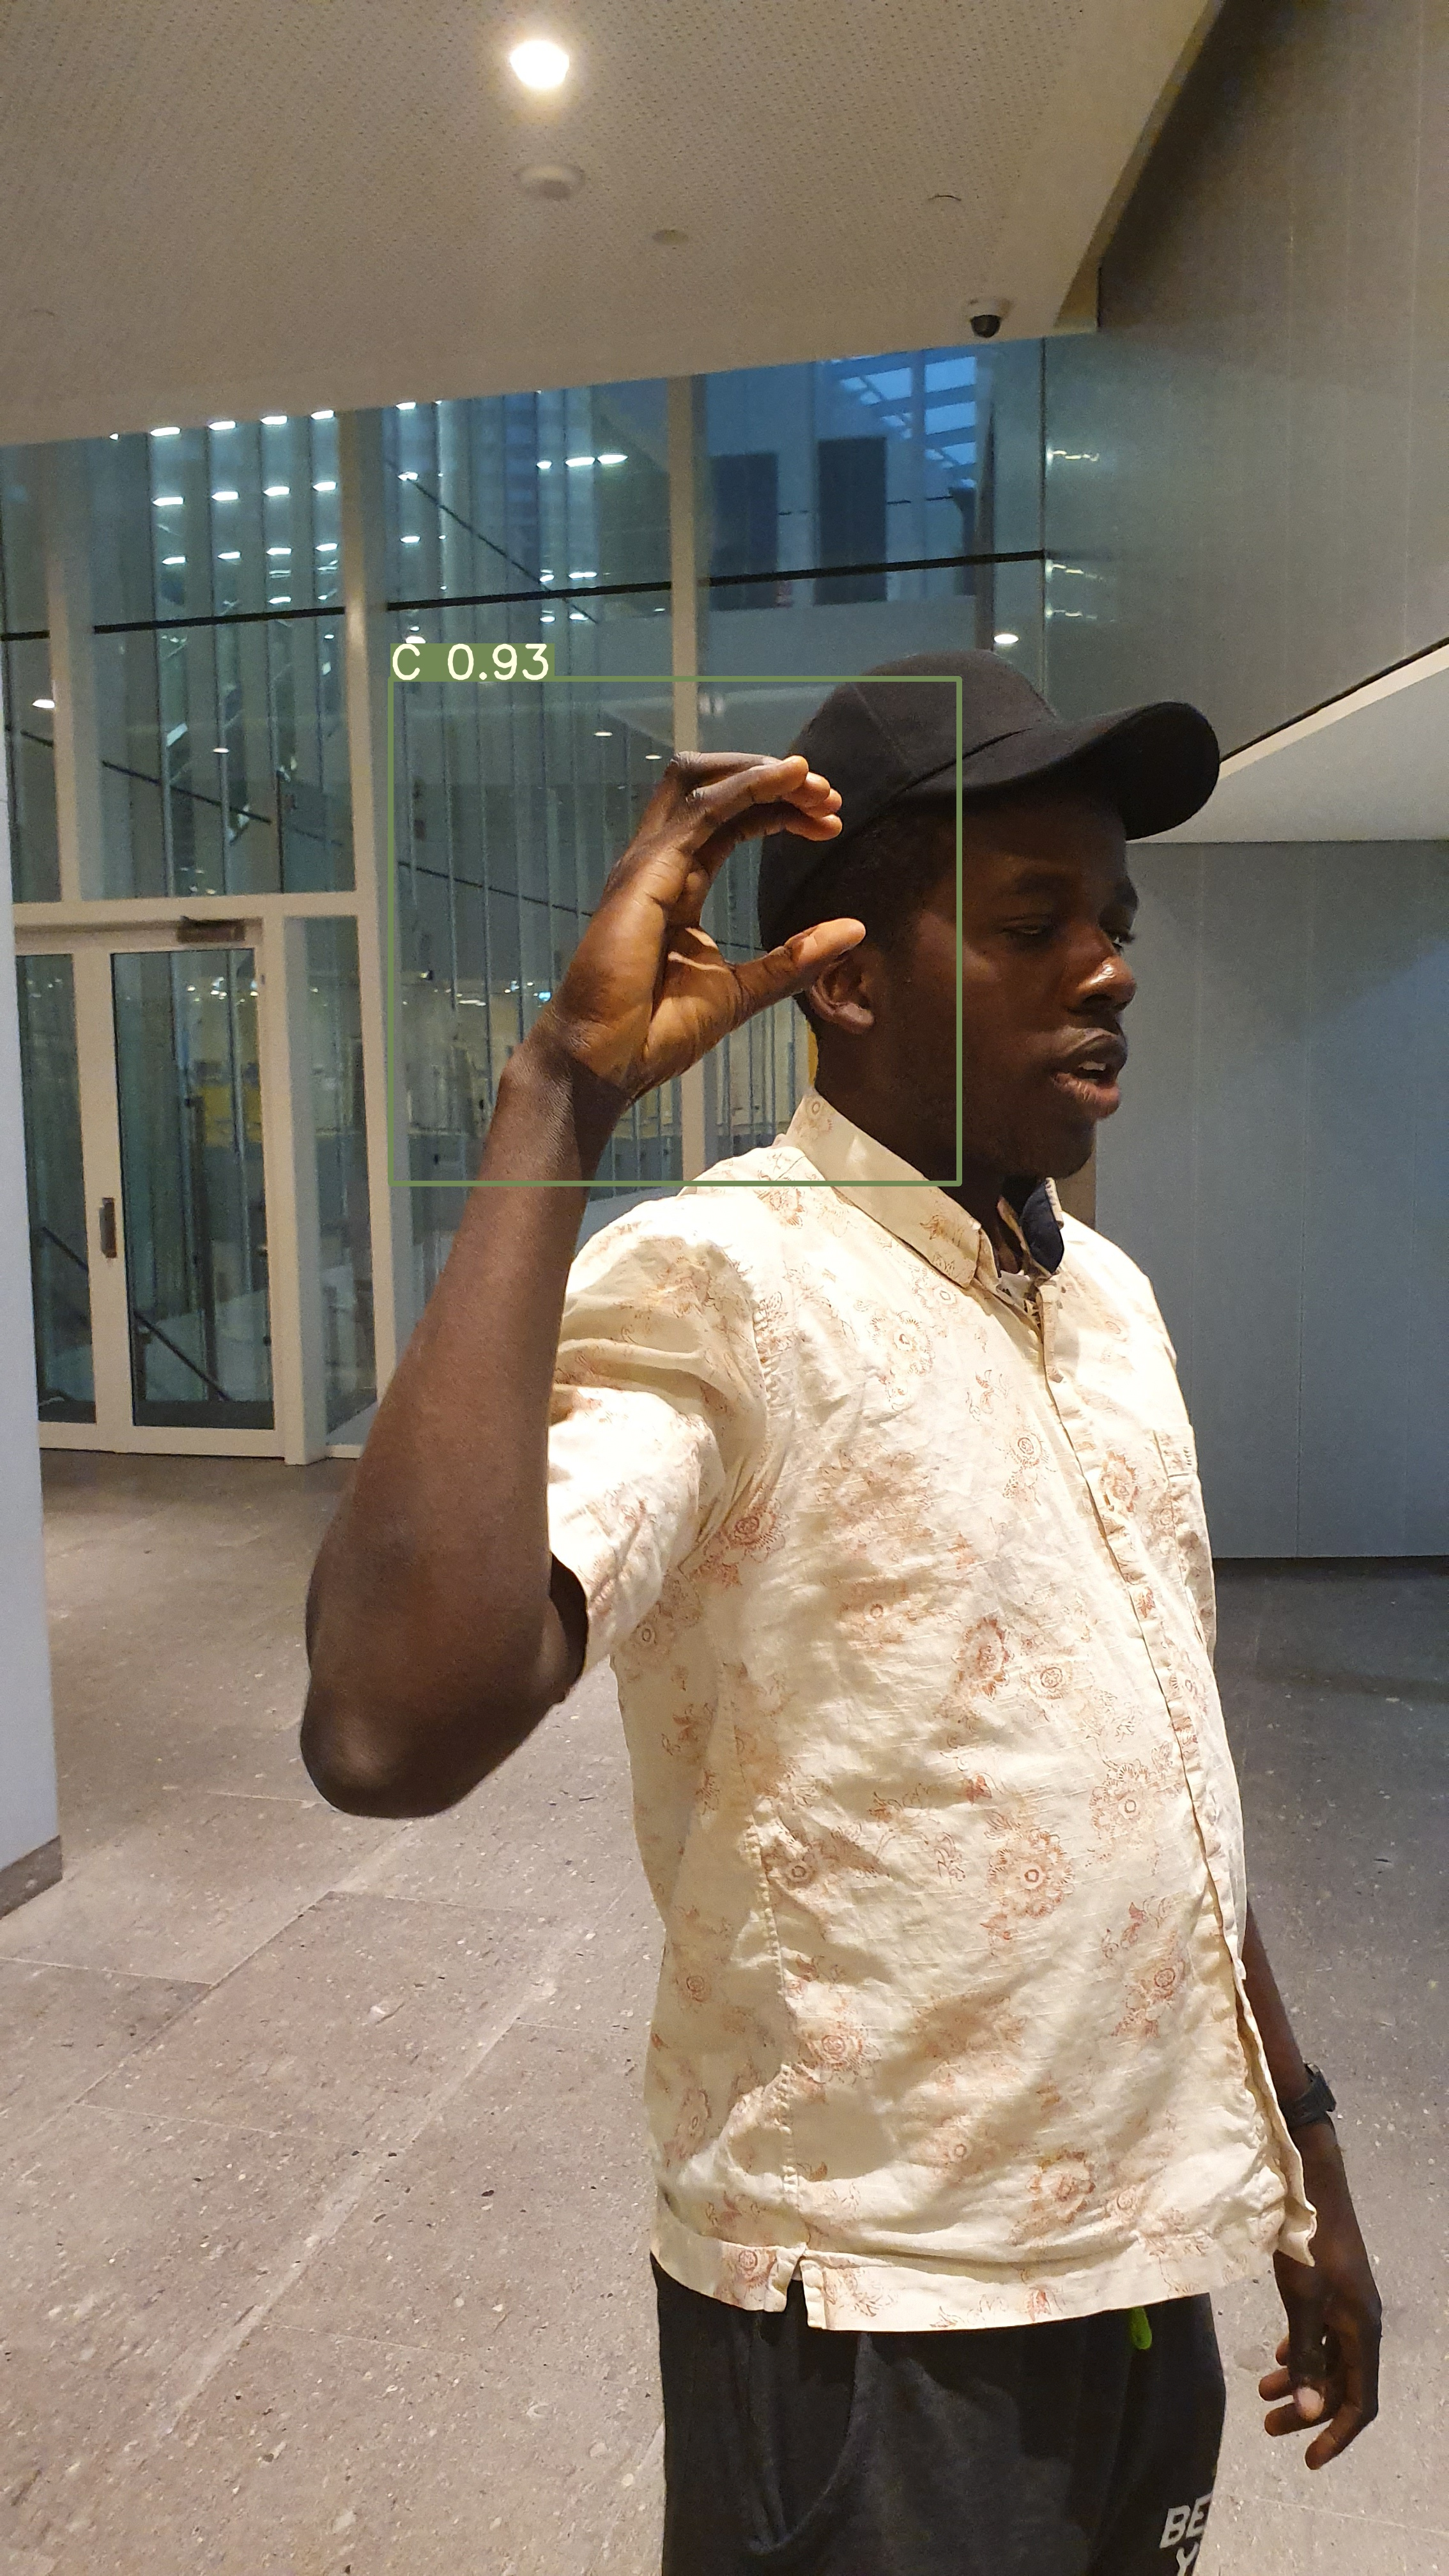

Results saved to /home/mmvc/mmvc-ad-teachnas/CV_2019_Fall/msn307/YOLOV3/yolov3/output
All detections complete. (0.477s)


In [26]:
with torch.no_grad():
    detect()
